<a href="https://colab.research.google.com/github/123ich/Web-extension-for-facial-expression-/blob/master/model%20training/Ensembling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install h5py pyymal

In [ ]:
!pip install tensorflowjs==3.8

In [ ]:
!pip install --upgrade packaging


#Project setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Average
import numpy as np
import os
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
data_dir2 = "/content/drive/MyDrive/affectNet/val_class"

In [ ]:
data_dir = "/content/drive/MyDrive/affectNet/train_class"

#Data loading and preparation

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 30017 files belonging to 6 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
data = data.map(lambda x,y: (x/255, y)) #rescaling data

In [ ]:
data.as_numpy_iterator().next()

In [ ]:
train=data.take(len(data))

In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(data_dir2)

Found 3000 files belonging to 6 classes.


In [ ]:
val_data_iterator = val_data.as_numpy_iterator()

In [ ]:
val_batch = val_data_iterator.next()

In [ ]:
val_data= val_data.map(lambda x,y: (x/255, y))

In [ ]:
val_data.as_numpy_iterator().next()

In [ ]:
#splitting data for validation and test
val_size = int(len(val_data)*.7)
test_size = int(len(val_data)*0.3)

In [ ]:
val = val_data.take(val_size)
test = val_data.take(test_size)

importing the trained models

In [ ]:
model= load_model('/content/drive/MyDrive/vgg19_classifier.h5')
model2 = load_model('/content/drive/MyDrive/Xception classifier35.h5')

ensembling both models into one using Average ensembling

In [ ]:
model_1 = Model(inputs=model1.inputs,
                outputs=model1.outputs,
                name='vgg19')
model_2 = Model(inputs=model2.inputs,
                outputs=model2.outputs,
                name='xception')
models = [model_1, model_2]
model_input = Input(shape=(256, 256, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
ensemble_model.compile(
  optimizer=tf.keras.optimizers.Adam(
    learning_rate= 1e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [ ]:
checkpoint_path="/content/drive/MyDrive/cp1.ckpt"

In [ ]:
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
hist =ensemble_model.fit(train, epochs=20, validation_data=val,callbacks=[cp_callback])


Epoch 1/20
939/939 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.6161
Epoch 1: saving model to /content/drive/MyDrive/cp1.ckpt
939/939 [==============================] - 422s 433ms/step - loss: 1.0416 - accuracy: 0.6161 - val_loss: 1.2231 - val_accuracy: 0.5389
Epoch 2/20
938/939 [============================>.] - ETA: 0s - loss: 1.0146 - accuracy: 0.6258
Epoch 2: saving model to /content/drive/MyDrive/cp1.ckpt
939/939 [==============================] - 391s 416ms/step - loss: 1.0146 - accuracy: 0.6258 - val_loss: 1.2150 - val_accuracy: 0.5404
Epoch 3/20
938/939 [============================>.] - ETA: 0s - loss: 0.9967 - accuracy: 0.6336
Epoch 3: saving model to /content/drive/MyDrive/cp1.ckpt
939/939 [==============================] - 390s 414ms/step - loss: 0.9967 - accuracy: 0.6336 - val_loss: 1.2119 - val_accuracy: 0.5428
Epoch 4/20
938/939 [============================>.] - ETA: 0s - loss: 0.9791 - accuracy: 0.6417
Epoch 4: saving model to /content/drive/

KeyboardInterrupt: ignored

In [ ]:
tf.keras.models.save_model(ensemble_model,'/content/drive/MyDrive/ensembeled_model_vf.h5')

In [ ]:
#renaming the layers to make sure we don't have any layers that have the same name, otherwise we won't be able to deploy it.
for layer in ensemble_model.layers:
    for weight in layer.weights:
        weight_name = weight.name
        layer_name = layer.name
        new_weight_name = layer_name + '_' + weight_name
        weight._handle_name = new_weight_name

#Testing

In [ ]:
classes=['neutral','happy','sad','surprise','fear','angry']

1/1 [==============================] - 0s 40ms/step
[[ 2.1031938  94.61912     0.86908656  1.6103327   0.37862444  0.41963825]]
happy


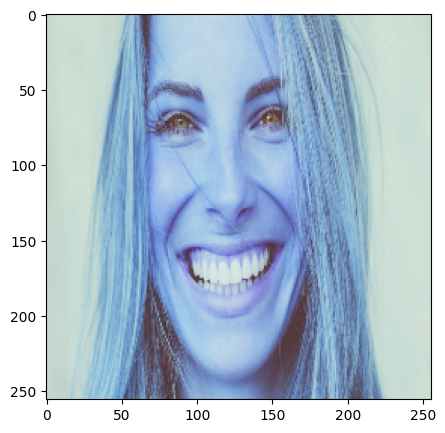

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
image=cv2.imread('/content/drive/MyDrive/how-to-be-happy.jpg')
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0
image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
yhat =model.predict(image_tensor)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(image)
print(classes(yhat[1].indexof(max(yhat[1])))

1/1 [==============================] - 0s 48ms/step
[[ 3.5141702  19.476166   59.890617    6.8840714   9.9567585   0.27822176]]
sad


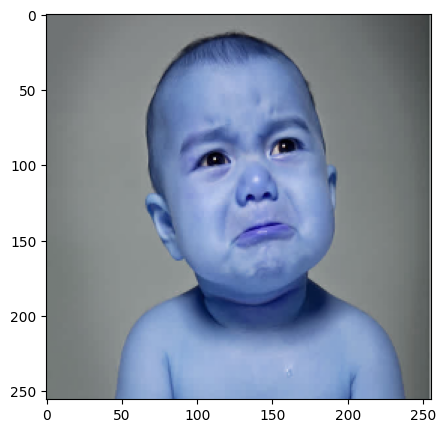

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
image=cv2.imread('/content/drive/MyDrive/image_2023-05-04_121745541.png')
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0
image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
yhat =model.predict(image_tensor)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(image)
print(yhat*100)
print(classes(yhat[1].indexof(max(yhat[1])))

1/1 [==============================] - 0s 40ms/step
[[28.592894   0.7925596 17.272366   4.2271547  5.363088  43.75194  ]]
angry


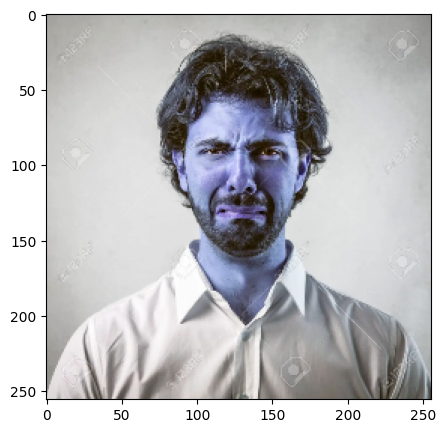

In [ ]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
image=cv2.imread('/content/drive/MyDrive/image_2023-05-04_120018535.png')
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0
image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
yhat =model.predict(image_tensor)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(image)
print(yhat*100)
print(classes(yhat[1].indexof(max(yhat[1])))

1/1 [==============================] - 0s 24ms/step
[[15.570564   0.1193071 19.507187  12.946049  46.967712   4.8891873]]
surprise


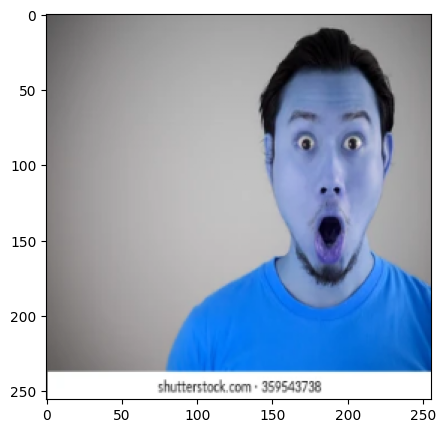

In [ ]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
image=cv2.imread('/content/drive/MyDrive/image_2023-05-04_123608643.png')
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0
image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
yhat =model.predict(image_tensor)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(image)
print(yhat*100)
print(classes(yhat[1].indexof(max(yhat[1])))

1/1 [==============================] - 0s 27ms/step
[[39.37378   15.4938135 37.542946   0.3227306  0.3339909  6.9327397]]
neutral


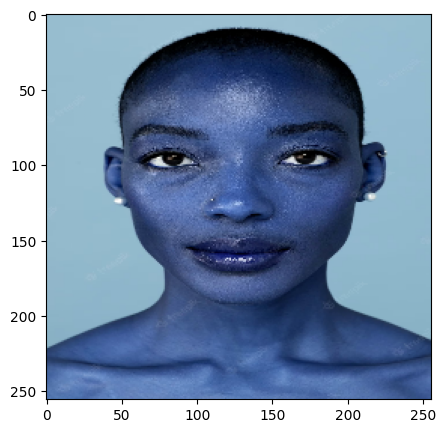

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
image=cv2.imread('/content/drive/MyDrive/image_2023-05-04_121414150.png')
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0
image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
yhat =model.predict(image_tensor)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(image)
print(yhat*100)
print(classes(yhat[1].indexof(max(yhat[1])))

1/1 [==============================] - 0s 39ms/step
[[3.5292034e+01 1.5187137e-02 6.8151922e+00 7.0212059e+00 5.0364922e+01
  4.9145985e-01]]
fear


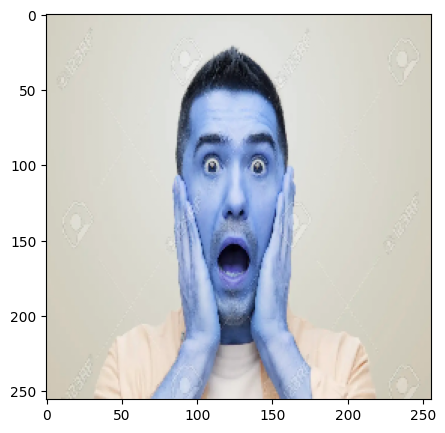

In [ ]:

import cv2
import numpy as np
from matplotlib import pyplot as plt
image=cv2.imread('/content/drive/MyDrive/image_2023-05-04_120645899.png')
image = cv2.resize(image, (256, 256))
image = image.astype(np.float32) / 255.0
image_tensor = tf.convert_to_tensor(np.expand_dims(image, axis=0), dtype=tf.float32)
yhat =model.predict(image_tensor)
fig, ax = plt.subplots(ncols=1, figsize=(5,5))
ax.imshow(image)
print(yhat*100)
print(classes(yhat[1].indexof(max(yhat[1])))

In [ ]:
test_loss, test_acc =model.evaluate(test,verbose=2)
print(test_acc)

28/28 - 20s - loss: 1.2026 - accuracy: 0.5480 - 20s/epoch - 705ms/step
0.5479910969734192


#Confusion matrix

In [ ]:
unbatched_dataset = test.unbatch()

In [ ]:
classes = unbatched_dataset.map(lambda x, y: y)

In [ ]:
array = np.array(list(classes.as_numpy_iterator()))

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.binary):
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    font = {
    'weight' : 'bold',
    'size'   : 22}
    plt.rc('font', **font)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
      cm = cm.astype('float') 
      cm = np.around(cm, decimals=2)
      cm[np.isnan(cm)] = 0.0
      print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from sklearn.metrics import classification_report, confusion_matrix
import itertools 

target_names = []
for key in val_data.class_names:
    target_names.append(key)
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')


94/94 [==============================] - 45s 386ms/step
Confusion Matrix


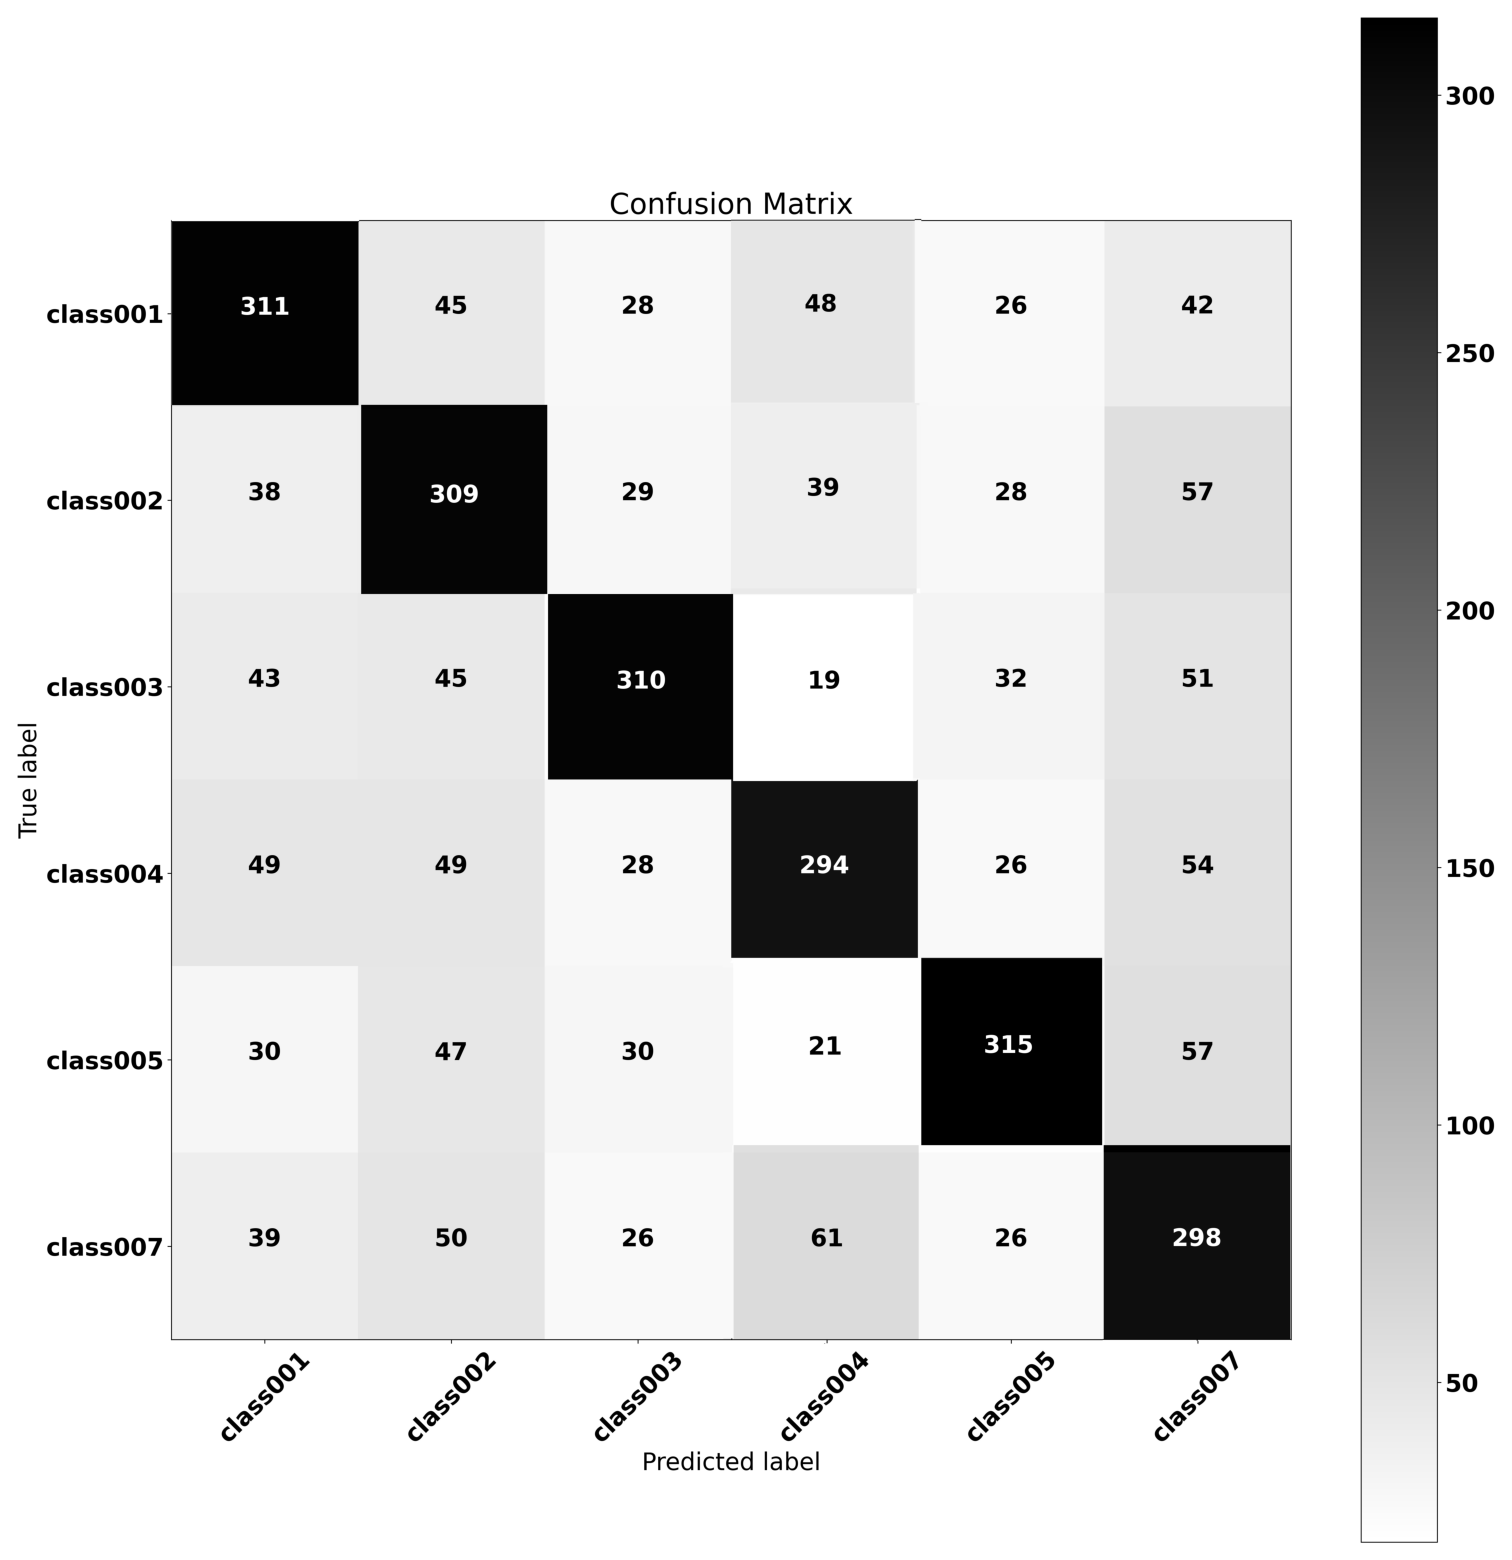

In [ ]:
cm = confusion_matrix(array, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

print('Classification Report')
print(classification_report(array, y_pred, target_names=target_names))